In [ ]:
! pip install -q "gdown==5.2.0"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id 1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39
From (redirected): https://drive.google.com/uc?id=1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39&confirm=t&uuid=69ebee6f-500c-4a3c-80f1-c18e696bd0db
To: /content/lung_cancer_dataset.zip
100% 178M/178M [00:02<00:00, 63.9MB/s]


In [ ]:
!unzip lung_cancer_dataset.zip

In [ ]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)


    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
data_dir = '/content/lung_cancer_dataset'
df = loading_the_data(data_dir)
df

,filepaths,labels
0,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
1,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
2,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
3,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
4,/content/lung_cancer_dataset/Normal cases/Norm...,Normal cases
...,...,...
1195,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1196,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1197,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1198,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases


# Custom Dataset

In [ ]:
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_dict=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        label = self.class_dict[label]
        label = torch.tensor(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing

In [ ]:
img_size = (224, 224)
batch_size = 32

In [ ]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

classes = train_df['labels'].unique()
class_dict = {label: idx for idx, label in enumerate(classes)}
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = LungCancerDataset(dataframe=train_df, transform=transform, class_dict=class_dict)
valid_dataset = LungCancerDataset(dataframe=valid_df, transform=transform, class_dict=class_dict)
test_dataset = LungCancerDataset(dataframe=test_df, transform=transform, class_dict=class_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Custom Model

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate):
        super(DenseBlock, self).__init__()
        self.dense = nn.Linear(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dense(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

# Custom EfficientNetB3 model with additional layers
class CustomEfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB3, self).__init__()
        # Load the pre-trained EfficientNetB3 model
        self.base_model = models.efficientnet_b3(weights='IMAGENET1K_V1')

        # Remove the top layer (classifier)
        self.base_model.classifier = nn.Identity()

        # Custom layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Equivalent to GlobalAveragePooling2D
        self.bn = nn.BatchNorm1d(1536)  # BatchNormalization after global pooling
        self.dense_block1 = DenseBlock(1536, 128, 0.5)
        self.dense_block2 = DenseBlock(128, 32, 0.2)
        self.classifier = nn.Linear(32, num_classes)    # Final output layer

    def forward(self, x):
        x = self.base_model.features(x)        # Pass through EfficientNetB3 base layers
        x = self.global_avg_pool(x)            # Apply global average pooling
        x = torch.flatten(x, 1)                # Flatten the output
        x = self.bn(x)                         # Apply batch normalization
        x = self.dense_block1(x)               # First dense block
        x = self.dense_block2(x)               # Second dense block
        x = self.classifier(x)                 # Final classification layer
        return x

# number of classes (3 classes: Normal, Benign, Malignant)
num_classes = 3

model = CustomEfficientNetB3(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 74.7MB/s]


In [ ]:
model

# Train

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Loss: 0.6025 | Accuracy: 0.8000
Validation Accuracy: 0.8833
Epoch 2/10 | Loss: 0.2871 | Accuracy: 0.9531
Validation Accuracy: 0.9750
Epoch 3/10 | Loss: 0.2597 | Accuracy: 0.9344
Validation Accuracy: 0.9083
Epoch 4/10 | Loss: 0.1758 | Accuracy: 0.9646
Validation Accuracy: 0.9417
Epoch 5/10 | Loss: 0.1684 | Accuracy: 0.9594
Validation Accuracy: 0.9667
Epoch 6/10 | Loss: 0.1354 | Accuracy: 0.9615
Validation Accuracy: 0.9917
Epoch 7/10 | Loss: 0.0827 | Accuracy: 0.9792
Validation Accuracy: 1.0000
Epoch 8/10 | Loss: 0.0732 | Accuracy: 0.9865
Validation Accuracy: 0.9500
Epoch 9/10 | Loss: 0.0819 | Accuracy: 0.9792
Validation Accuracy: 0.9417
Epoch 10/10 | Loss: 0.0972 | Accuracy: 0.9750
Validation Accuracy: 1.0000


# Test

In [ ]:
# Test the model
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9917


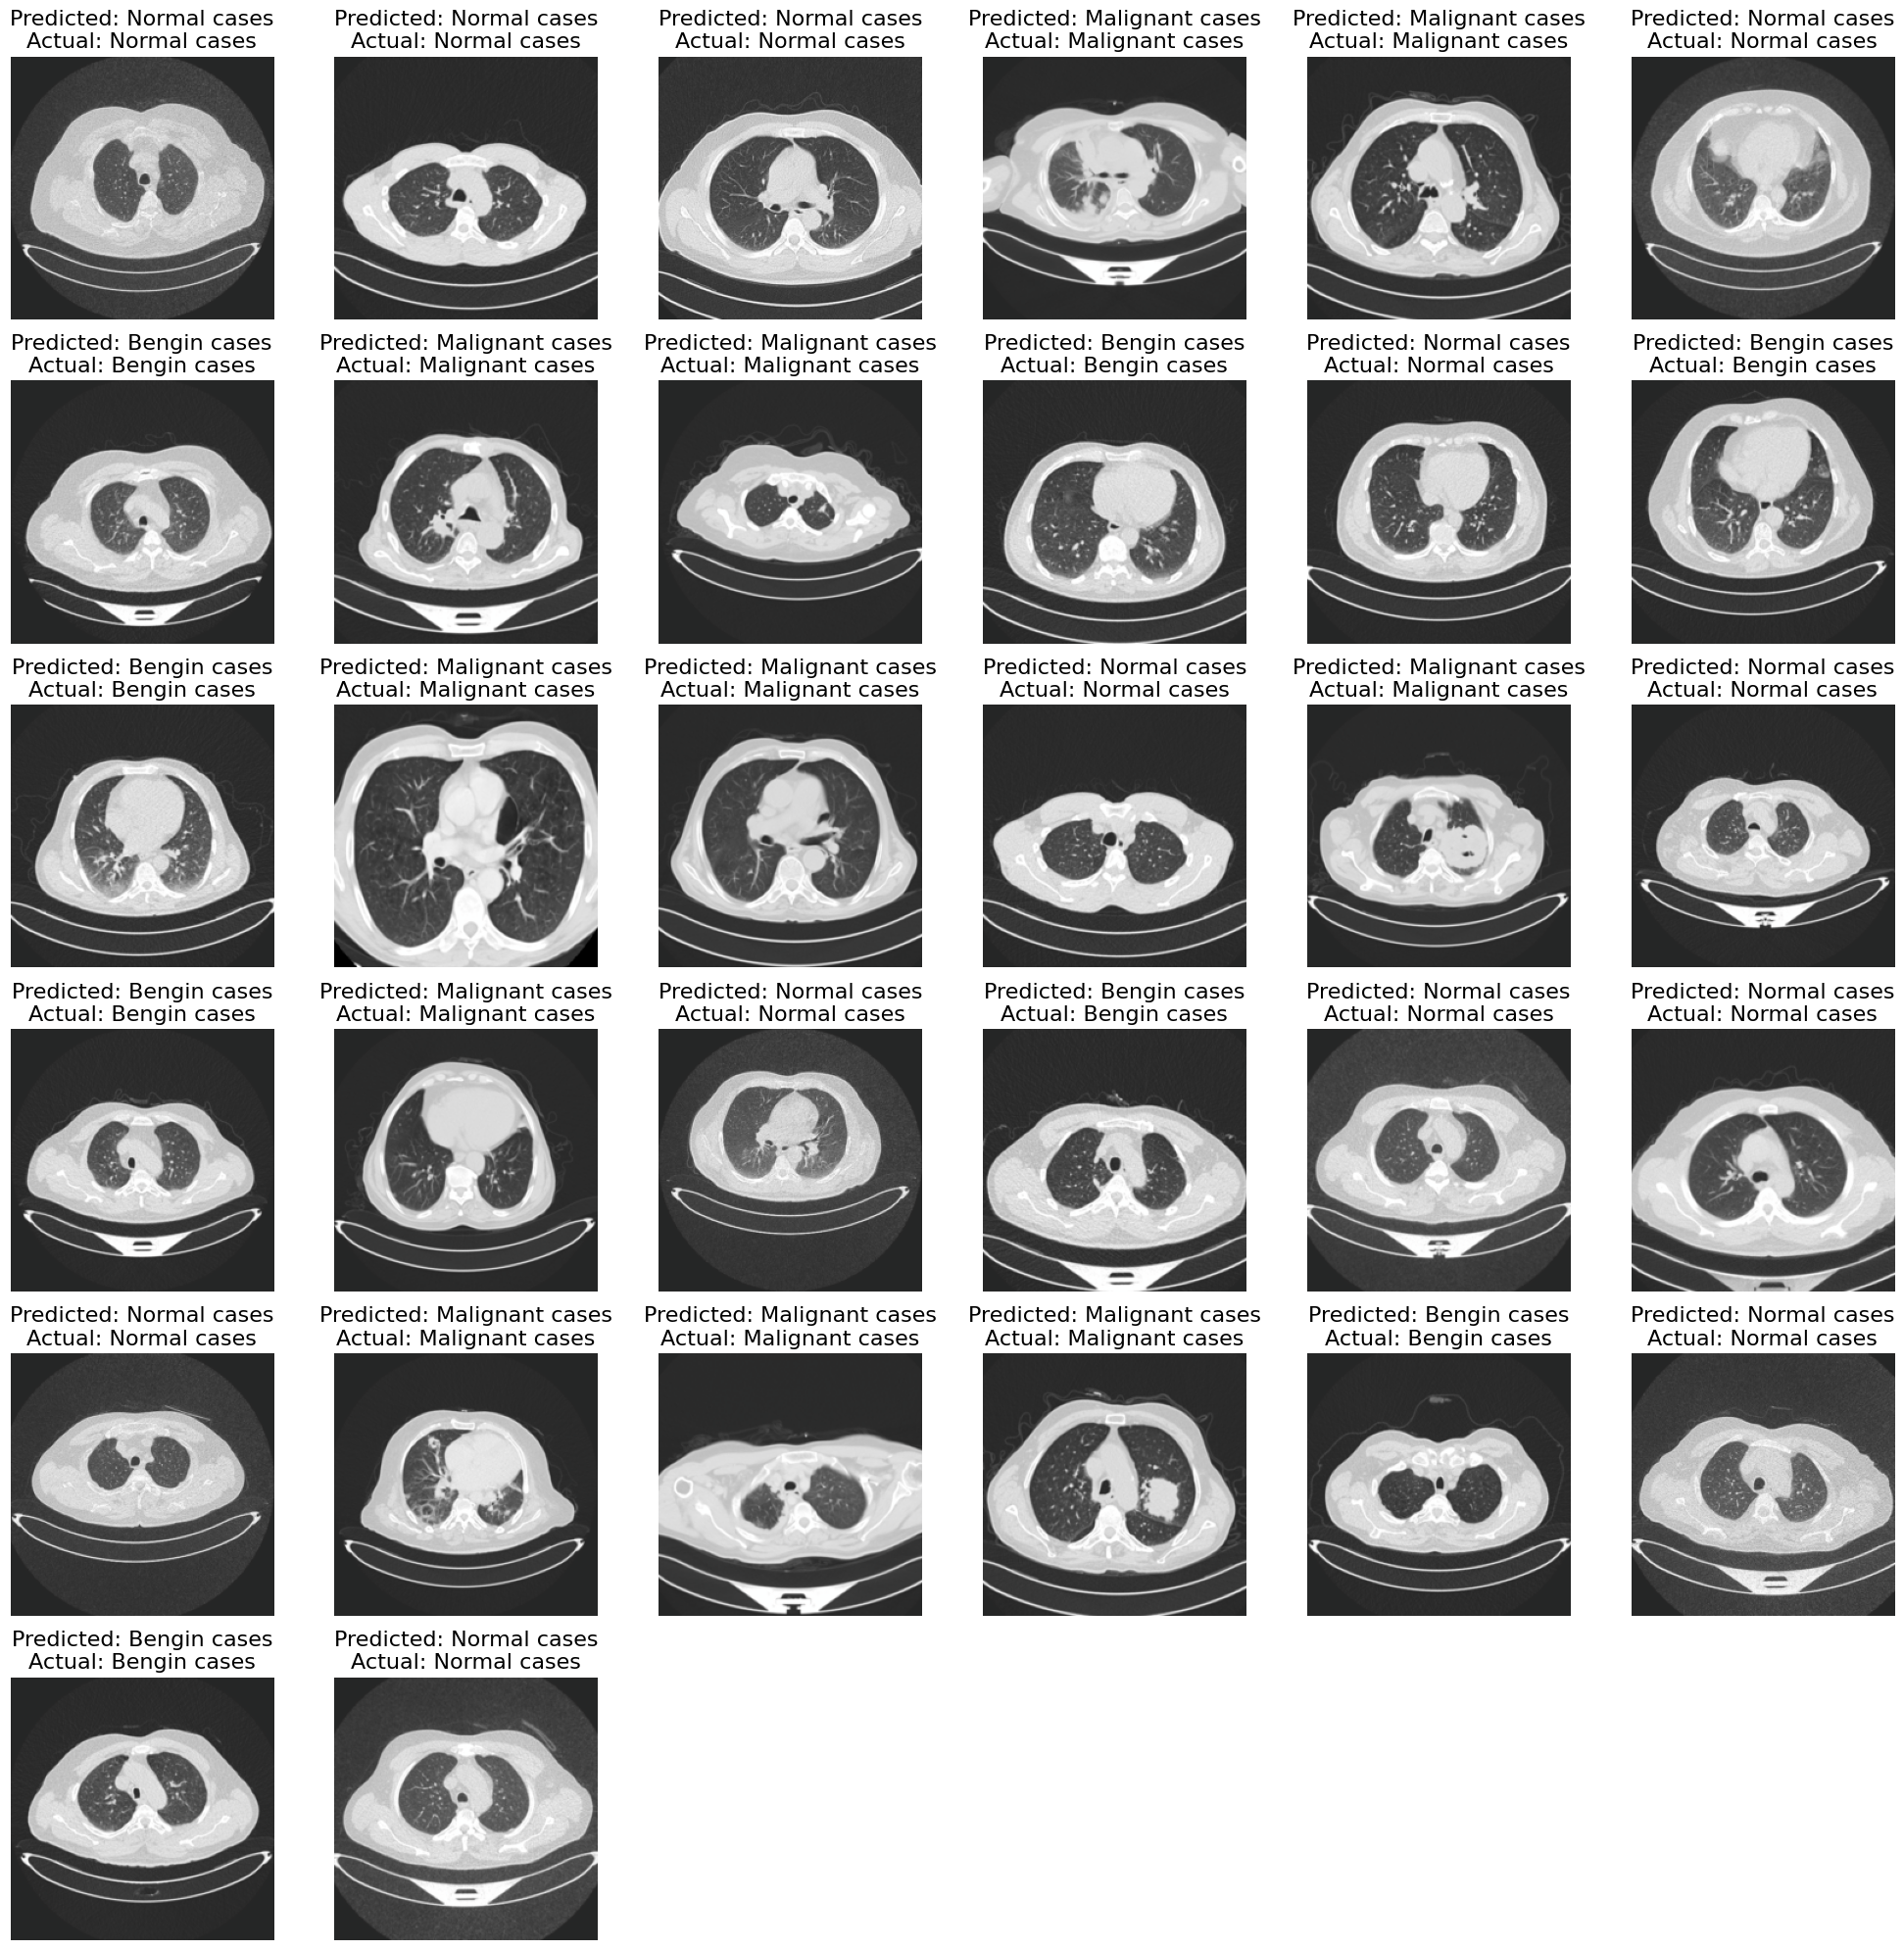

In [ ]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Convert images to CPU and unnormalize
inputs = inputs.cpu().numpy().transpose(0, 2, 3, 1)
inputs = np.clip(inputs * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

plt.figure(figsize=(20, 20))
for i in range(len(inputs)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(inputs[i])
    plt.title(f'Predicted: {reverse_class_dict[preds[i].item()]}\nActual: {reverse_class_dict[labels[i].item()]}', color='black', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()
